In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


# Load and Visualize

In [3]:
class VehicleDataset(Dataset):
    
    def __init__(self, path):
        data = np.load(path)
        self.images = data["images"]
        self.labels = data["labels"]
        
        print("Images shape:", self.images.shape)
        print("Labels shape:", self.labels.shape)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [4]:
dataset = VehicleDataset('../dataset/stanford_cars_dataset.npz')

batch_size = 32
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = int(len(dataset) - train_size - val_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Images shape: (8144, 112, 112, 3)
Labels shape: (8144, 1)


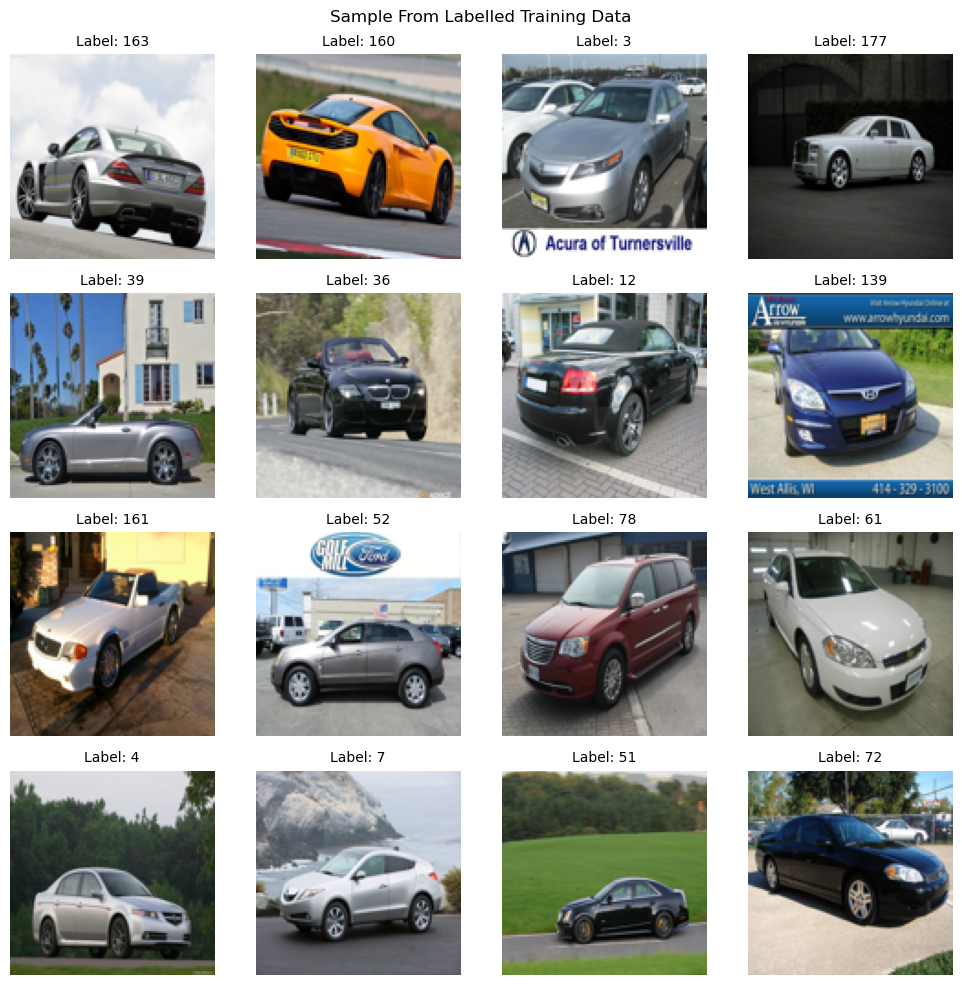

In [5]:
for images, labels in train_loader:
    break 

# Create figure
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = images[i].permute(1, 2, 0).numpy() 
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}", fontsize=10)
    axes[i].axis("off")

plt.suptitle("Sample From Labelled Training Data")
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

# GoogLe Inception v1
- 64x64 input (vehicle image dataset)
- 196 Classes

In [6]:
class Inception(nn.Module):

    def __init__(self, in_channels, channels1x1, channels3x3_reduce, channels3x3, channels5x5_reduce, channels_5x5, pool_proj):
        super(Inception, self).__init__()

        self.block1 = nn.Conv2d(in_channels, channels1x1, kernel_size=1)
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels, channels3x3_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels3x3_reduce, channels3x3, kernel_size=3, padding=1)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels, channels5x5_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels5x5_reduce, channels_5x5, kernel_size=5, padding=2)
        )

        self.block4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        
        b1 = self.block1(x)
        b2 = self.block2(x)
        b3 = self.block3(x)
        b4 = self.block4(x)
        
        return torch.cat([b1, b2, b3, b4], 1)

In [7]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=196):
        super(GoogLeNet, self).__init__()

        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.maxpool4 = nn.MaxPool2d(2, stride=2)

        self.inception5a = Inception(512, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 196)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Training

In [10]:
def train_model(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 15
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels[:,0].to(device) - 1

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")
    
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels[:,0].to(device) - 1
            
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f'Validation Acc: {val_acc:.4f}')

In [11]:
googlenet = GoogLeNet().to(device)
train_model(googlenet)

100%|██████████| 179/179 [00:49<00:00,  3.61it/s]


Epoch 1/15 - Loss: 5.2807 - Accuracy: 0.0051
Validation Acc: 0.0049


100%|██████████| 179/179 [00:49<00:00,  3.61it/s]


Epoch 2/15 - Loss: 5.2774 - Accuracy: 0.0060
Validation Acc: 0.0106


100%|██████████| 179/179 [00:49<00:00,  3.61it/s]


Epoch 3/15 - Loss: 5.2759 - Accuracy: 0.0074
Validation Acc: 0.0106


100%|██████████| 179/179 [00:49<00:00,  3.59it/s]


Epoch 4/15 - Loss: 5.2593 - Accuracy: 0.0086
Validation Acc: 0.0147


100%|██████████| 179/179 [00:49<00:00,  3.58it/s]


Epoch 5/15 - Loss: 5.2087 - Accuracy: 0.0105
Validation Acc: 0.0131


100%|██████████| 179/179 [00:49<00:00,  3.59it/s]


Epoch 6/15 - Loss: 5.1827 - Accuracy: 0.0105
Validation Acc: 0.0106


100%|██████████| 179/179 [00:49<00:00,  3.58it/s]


Epoch 7/15 - Loss: 5.1706 - Accuracy: 0.0098
Validation Acc: 0.0164


100%|██████████| 179/179 [00:49<00:00,  3.58it/s]


Epoch 8/15 - Loss: 5.1634 - Accuracy: 0.0107
Validation Acc: 0.0131


100%|██████████| 179/179 [00:50<00:00,  3.58it/s]


Epoch 9/15 - Loss: 5.1551 - Accuracy: 0.0140
Validation Acc: 0.0164


100%|██████████| 179/179 [00:49<00:00,  3.58it/s]


Epoch 10/15 - Loss: 5.1489 - Accuracy: 0.0114
Validation Acc: 0.0123


100%|██████████| 179/179 [00:49<00:00,  3.58it/s]


Epoch 11/15 - Loss: 5.1447 - Accuracy: 0.0135
Validation Acc: 0.0147


100%|██████████| 179/179 [00:50<00:00,  3.58it/s]


Epoch 12/15 - Loss: 5.1359 - Accuracy: 0.0151
Validation Acc: 0.0115


100%|██████████| 179/179 [00:50<00:00,  3.58it/s]


Epoch 13/15 - Loss: 5.1265 - Accuracy: 0.0114
Validation Acc: 0.0106


100%|██████████| 179/179 [00:50<00:00,  3.58it/s]


Epoch 14/15 - Loss: 5.1160 - Accuracy: 0.0142
Validation Acc: 0.0156


100%|██████████| 179/179 [00:50<00:00,  3.58it/s]


Epoch 15/15 - Loss: 5.1093 - Accuracy: 0.0130
Validation Acc: 0.0180


# Testing

In [17]:
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels[:,0].to(device) - 1
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Concatenate all predictions and labels if needed for further analysis
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    return accuracy, all_preds, all_labels

In [21]:
torch.set_printoptions(profile="full")
test_model(googlenet, test_loader, device)

Test Accuracy: 0.0139


(0.013900245298446443,
 tensor([108, 152,  78, 108, 108, 108, 108,  78,  78, 108, 152, 152, 108, 152,
         118, 108, 118, 108, 108,  96, 151, 108, 108, 108, 118, 152, 118, 108,
           0, 152,  78, 108, 118, 108, 102,  78, 118,  78, 108, 118, 118, 108,
         152,  91, 118, 152, 108, 108, 118, 118, 108, 118, 108, 118, 118, 108,
         152,  78, 108, 108, 118, 111, 108, 152, 108, 108, 108,  43, 152, 108,
         108, 108, 108, 108, 108, 118, 151, 108, 152, 108, 108, 118, 108, 108,
          78, 108, 108, 108, 108,  43, 118, 108, 118, 118, 108, 108, 108, 152,
         108, 108, 108, 118, 118, 108, 108, 108, 108,  78, 118, 118, 152, 108,
         108, 118, 152, 108,  43, 108, 108,  43,  96,  78, 108, 118, 108, 108,
         152, 108, 108, 152, 108,  78, 152, 108, 118, 108, 118,  78,  43, 118,
         108, 108,  78, 152, 108, 118, 108, 118, 152, 118, 152, 118, 118, 118,
         118,  78, 111,  43, 152, 118, 108, 108,  43, 118,  78, 108, 108,  43,
         108, 118, 108,  43, 